### System

The total Hamiltonian of the system is given by:

$
H = H_0 + H_{\text{SB}} = H_{\text{S}} + H_{\text{B}} + H_{\text{SB}}
$

where:
- $ H_{\text{S}} $ is the system Hamiltonian
- $ H_{\text{B}} $ is the bath Hamiltonian
- $ H_{\text{SB}} $ is the system-bath interaction Hamiltonian

#### System Hamiltonian

The system Hamiltonian $ H_{\text{S}} $ is modeled as a two level system:

$
H_{\text{S}} = \hbar \omega_a |e\rangle\langle e|
$

is defined by a two level system with ground state $ |g\rangle $, seperated from an excited state $ |e\rangle $ by $ \omega_a $.
The atom is polarized in the z direction


### The Coupling to the Environment is modeled with 
#### The Redfield Equation

... derivation from paper / Danis darivation...


The system-bath coupling is written in a general form as:

$
H_{SB} =  \sum_i S_i \otimes B_i,
$

where the coupling operators $ S_i $  are modeled as $ \sigma_z $ for dephasing and $ \sigma_x $ for relaxation.
and the different baths are uncorrelated. The correlation functions thus can be written as: 

$
C_{ij}(t) \equiv \langle B_i(t) B_j \rangle_B \equiv \delta_{ij} \langle B_i(t) B_j \equiv C_i(t)
$

Each System operator couples to its own bath.

**The SB interaction is treated within a linear response theory**: The monomers are linearly coupled to the bath oscillators and the coupling function $ F_i $ is specified as:

$
B_i = \sum_x g_x^i q_x^i =\sum_x g_x^i (a_x^{\dagger} + a_x) 
$

where the coupling parameter $ g_x^i $ describe the interaction of the system operator with mode $ x $ of the $ i-th $ bath.

For a bath of harmonic oscillators, analytic expressions for the bath correlation function (CF) and its Fourier transform can be obtained:

$
C_i(t) = \frac{1}{2} \sum_x (g_x^{(i)})^2 \left[ n(\omega_x) e^{i\omega_x t} + (1 + n(\omega_x)) e^{-i\omega_x t} \right],
$

where $ n(\omega) = 1 / (e^{\hbar\omega/k_B T} - 1) $ is the Bose-Einstein distribution function.

The spectral density function, $ J_i(\omega) $, which entirely describes the parameters of the bath, is defined for each monomer as:

$
J_i(\omega) = \frac{\pi}{2} \sum_x (g_x^{(i)})^2 \delta(\omega - \omega_x).
$

For convenience, we assume that the spectral density for both monomers is equivalent. For the calculations in this paper, the spectral density is taken to be of the form:

$
J(\omega) = g^2 \frac{\omega}{\omega_{\text{c}}} e^{-\omega/\omega_{\text{c}}},
$

where $ \omega_{\text{c}} $ is a cutoff frequency and $ g^2 $ is a dimensionless coupling strength parameter.


In [1]:
### IMPORTS ###
from bath_constants import (
    Boltzmann,
    hbar,
    ############## Bath parameters ##############
    Temp,
    eta,
    cutoff,
    args_drude_lorentz,
    args_ohmic,
)
# functions from test_baths.py
from test_baths import (
    spectral_density_func_ohmic,
    spectral_density_func_drude_lorentz,
)
import matplotlib.pyplot as plt
from qutip import *
import numpy as np

# Import the outsourced plot settings
from plot_settings import *

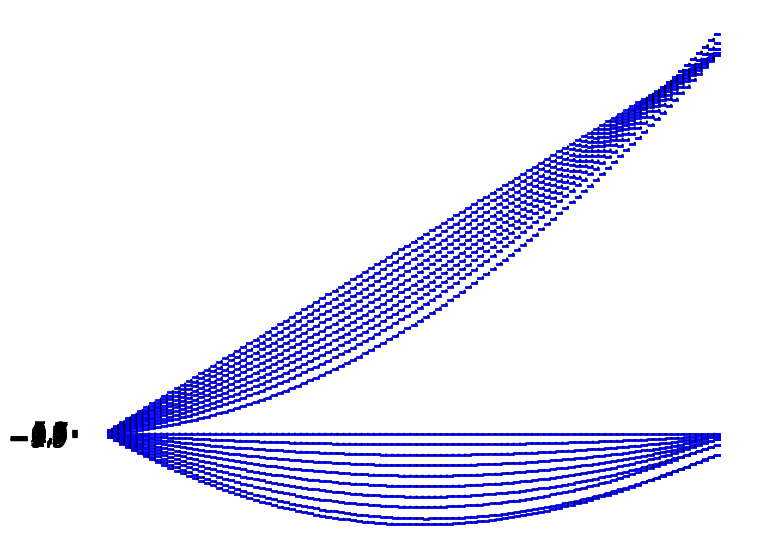

In [2]:
# =============================
# SYSTEM PARAMETERS     (**changeable**) 
# =============================
global Bath, omega_a, mu_a, rabi_0, delta, n_th
omega_a = 1 * 2 * np.pi # energy separation of the atomic states
mu_a = .1 * omega_a      # dipole moment of the transition
n_th = 1e-6

decay_ops_strg = ( # which decay channels are present
#    "Relax_at", # TODO DOESNT quite work how i want it to
    "Relax_cav",
#    "Deph_at",
#    "Deph_cav",
)

e_ops_strg = ( # which observables to keep track of
#    "sx",
#    "sy",
#    "sz",
    "n_at",
    "n_cav",
)

Bath = "OHMIC"          # Choose between "OHMIC" or DRUDE LORENTZ "DL"
if Bath == "OHMIC":
    bath_args = args_ohmic
    bath_model = spectral_density_func_ohmic
elif Bath == "DL":
    bath_args = args_drude_lorentz
    bath_model = spectral_density_func_drude_lorentz
else:
    raise ValueError("Invalid Bath type. Choose between 'OHMIC' or 'DL'.")

bath_args["cutoff"] = cutoff * omega_a # Adjust the cutoff frequency of the bath model based on the atomic frequency

### Define Atomic / Cavity States and Hamiltonian
atom_g, atom_e = basis(2, 0), basis(2, 1)  # Ground, Excited states

sm_op = atom_g * atom_e.dag()
dip_op = mu_a * (sm_op + sm_op.dag())

sx_op = (sm_op + sm_op.dag())  # sigmaX operator
sy_op = -1j * (atom_e * atom_g.dag() - atom_g * atom_e.dag())  # sigmaY operator
sz_op = atom_e * atom_e.dag() - atom_g * atom_g.dag()  # sigmaZ operator
n_at_op = ket2dm(atom_e) # number operator for the atom


# Cavity
N_cav = 10
omega_c = omega_a
a_op = destroy(N_cav)
n_cav_op = a_op.dag() * a_op  # number operator for the cavity

# combined operators
A_op = tensor(a_op, qeye(2))
SM_op = tensor(qeye(N_cav), sm_op)
SX_op = tensor(qeye(N_cav), sx_op)
SY_op = tensor(qeye(N_cav), sy_op)
SZ_op = tensor(qeye(N_cav), sz_op)

N_at_op = tensor(qeye(N_cav), n_at_op)
N_cav_op = tensor(n_cav_op, qeye(2))

g = 5e-2 * omega_a  # coupling strength

def Hamilton(omega_a, omega_c, g):
    H0 = (
         omega_a * SM_op.dag() * SM_op                    # atom energy seperation 
       + omega_c * A_op.dag() * A_op                        # cavity energy seperation
       + g * (A_op + A_op.dag()) * (SM_op + SM_op.dag()) # interaction
    )
    return H0

H0 = Hamilton(omega_a, omega_c, g)

# =============================
# PLOT ENERGY LEVELS
# =============================
frequencies = np.linspace(-0.1* omega_a, 0.1* omega_a, 101)
H_list = [Hamilton(omega_a, wc, g) for wc in frequencies]
plot_energy_levels(H_list)


### Coupling to the bath
# Linblad Case
gamma_phi, gamma_0_at = 1,1 #eta , eta / 3  # (**changeable**):  Dephasing and Decay rates with MESOLVE
gamma_0_cav = 0.05

def create_decay_ops_from_strg(strg):
    psi_ini_at = atom_e   # initial state
    # unpack the string
    a_ops_list = []
    c_ops_list = []
    gamma_br = 0
    gamma_me = 0

    if "Deph_at" in strg:
        psi_ini_at = (atom_e + atom_g).unit()   # initial state
        
        bath_args_deph = bath_args.copy()
        bath_args_deph["eta"] = np.sqrt(gamma_phi)

        a_ops_list.append(
            [sz_op, lambda w: np.sqrt(gamma_phi) * (w > 0)]#bath_model(w, bath_args_deph)]  # Dephasing operator
        )
        c_ops_list.append(
            np.sqrt(gamma_phi) * sz_op  # Collapse operator for dephasing
        )

        gamma_br = gamma_phi
        gamma_me = gamma_phi

    if "Relax_at" in strg:

        bath_args_rela = bath_args.copy()
        bath_args_rela["eta"] = np.sqrt(gamma_0_at)

        w_th = omega_a/np.log(1 + 1/n_th)

#        def S_w(w):
#            if w >= 0:
#                return (n_th + 1) * gamma_0_at
#            else:
#                return (n_th + 1) * gamma_0_at * np.exp(w / w_th)      
#        a_ops_list.append([
#            SM_op + SM_op.dag(), 
#            lambda w: S_w(w)
#            ]#* (w > 0)]#bath_model(w, bath_args_rela)]  # Relaxation operator
#        )

        a_ops_list.append([
            SM_op + SM_op.dag(), 
            lambda w: np.sqrt(gamma_0_at * n_th) + np.sqrt(gamma_0_at * (n_th + 1)) * np.exp(w / w_th)
            * (w > 0)
            ]#bath_model(w, bath_args_rela)]  # Relaxation operator
        )
        c_ops_list.append([
            SM_op       * np.sqrt(gamma_0_at * n_th),  # Collapse operator for relaxation
            SM_op.dag() * np.sqrt(gamma_0_at * (n_th + 1))  # Collapse operator for relaxation
            ]
        )

        gamma_br = gamma_0_at
        gamma_me = gamma_0_at

# THIS ONE REPRESENT THE SPONTANEOUS COUPLING between the atom and the cavity!! 
    if "Relax_cav" in strg:
        a_ops_list.append([
            (A_op + A_op.dag()),
            lambda w : gamma_0_cav*(w > 0)
            ]
        )
        c_ops_list.append([
            A_op * np.sqrt(gamma_0_cav)
            ]
        )

        gamma_br = gamma_0_cav
        gamma_me = gamma_0_cav
        
    if "Relax_at" in strg and "Deph_at" in strg:
        psi_ini_at = (atom_e + atom_g).unit()   # initial state

        gamma_br = (gamma_0_at + gamma_phi) / 2
        gamma_me = (gamma_0_at + gamma_phi) / 2
    
    psi_ini = tensor(basis(N_cav, 1), psi_ini_at)
    
    return a_ops_list, c_ops_list, gamma_br, gamma_me, psi_ini


def create_e_ops_from_strg(strg):
    e_ops_list = []
    e_ops_labels = []
    if "sx" in strg:
        e_ops_list.append(
            SX_op
        )
        e_ops_labels.append(
            r"$ \langle s_x \rangle $ "
        )

    if "sy" in strg:
        e_ops_list.append(
            SY_op
        )
        e_ops_labels.append(
            r"$ \langle s_y \rangle $ "
        )

    if "sz" in strg:
        e_ops_list.append(
            SZ_op
        )
        e_ops_labels.append(
            r"$ \langle s_z \rangle $ "
        )

    if "n_at" in strg:
        e_ops_list.append(
            N_at_op
        )
        e_ops_labels.append(
            r"$ \langle n_{\text{at}} \rangle $ "
        )
    if "n_cav" in strg:
        e_ops_list.append(
            N_cav_op
        )
        e_ops_labels.append(
            r"$ \langle n_{\text{cav}} \rangle $ "
        )
    return e_ops_list, e_ops_labels

a_ops_list, c_ops_list, gamma_br, gamma_me, psi_ini = create_decay_ops_from_strg(decay_ops_strg)

e_ops_list, e_ops_labels = create_e_ops_from_strg(e_ops_strg)

#print(a_ops_list, c_ops_list)
#print(gamma_br, gamma_me)

 Total run time:  21.14s*] Elapsed 21.13s / Remaining 00:00:00:00[*********90%*********  ] Elapsed 19.55s / Remaining 00:00:00:02
 Total run time:  19.72s*] Elapsed 19.72s / Remaining 00:00:00:00          1%           ] Elapsed 0.48s / Remaining 00:00:00:47[          2%           ] Elapsed 0.49s / Remaining 00:00:00:23[*         3%           ] Elapsed 0.85s / Remaining 00:00:00:27[*         4%           ] Elapsed 1.09s / Remaining 00:00:00:26[*         5%           ] Elapsed 1.31s / Remaining 00:00:00:24[*         5%           ] Elapsed 1.37s / Remaining 00:00:00:25[*         6%           ] Elapsed 1.49s / Remaining 00:00:00:23[*         6%           ] Elapsed 1.58s / Remaining 00:00:00:24[*         6%           ] Elapsed 1.67s / Remaining 00:00:00:26[*         6%           ] Elapsed 1.75s / Remaining 00:00:00:27[**       10%           ] Elapsed 2.47s / Remaining 00:00:00:22[***      12%           ] Elapsed 2.91s / Remaining 00:00:00:21[***      13%           ] Elapsed 3.35s / Remainin

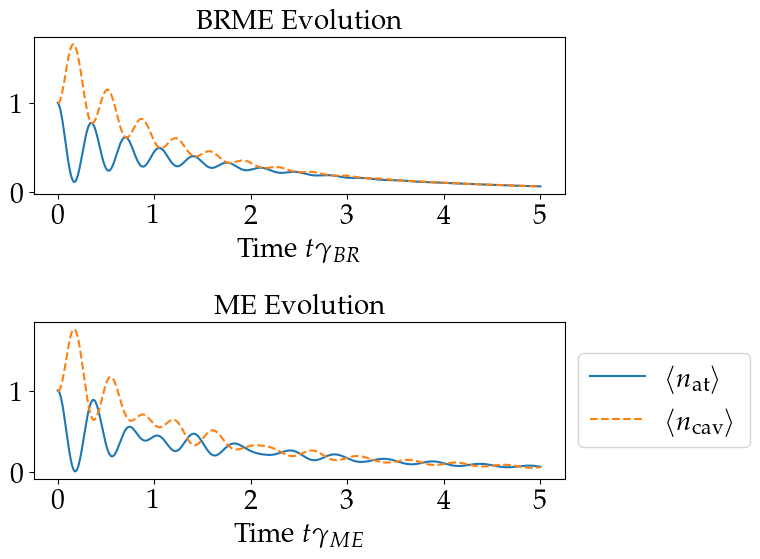

In [4]:
times_br = np.linspace(
    0,
    5 * 2 * np.pi / g,
    #10 / gamma_br
    1000
)  # High-resolution times array to do the evolutions
times_me = np.linspace(
    0,
    5 * 2 * np.pi / g,
    #10 / gamma_me,
    1000
)  # High-resolution times array to do the evolutions

options = {
    "store_states": True,
    "progress_bar": "enhanced",
}  # Store states for further analysis

### compute the evolution
result_brme = brmesolve(
    H0,
    psi_ini,
    times_br,
    e_ops=e_ops_list,
    a_ops=a_ops_list,
    options=options,
)

result_me = mesolve(
    H0,
    psi_ini,
    times_me,
    e_ops=e_ops_list,
    c_ops=c_ops_list,
    options=options,
)
# =============================
# PLOT EVOLUTION
# =============================
plt.figure(figsize=(8, 6))

### Plot result_brme
plt.subplot(2, 1, 1)
for i, e_op in enumerate(e_ops_list):
    plt.plot(
        np.array(result_brme.times) * gamma_br,
        result_brme.expect[i],
        label=e_ops_labels[i],
        linestyle=['solid', 'dashed', 'dashdot', 'dotted'][i % 4],  # Alternate line styles
        color=f'C{i}',  # Use distinct colors
    )
plt.xlabel(r'Time $t \gamma_{BR}$')
plt.title(r'BRME Evolution')
plt.ticklabel_format(style='plain', axis='both')

### Plot result_me
plt.subplot(2, 1, 2)
for i, e_op in enumerate(e_ops_list):
    plt.plot(
        np.array(result_me.times) * gamma_me,
        result_me.expect[i],
        label=e_ops_labels[i],
        linestyle=['solid', 'dashed', 'dashdot', 'dotted'][i % 4],  # Alternate line styles
        color=f'C{i}',  # Use distinct colors
    )
plt.xlabel(r'Time $t \gamma_{ME}$')
plt.title(r'ME Evolution')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.ticklabel_format(useOffset=False, style='plain')

plt.tight_layout()
plt.show()